In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# TorchVision Object Detection Finetuning Tutorial


Importing the required libraries

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

import os
import torch

import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor



Donwloading and extracting the dataset

In [ ]:

zipurl = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp .read())) as zfile:
    zfile . extractall( "." )

Q.5.a)
Defining the PennFudanDataset Class

In [ ]:

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Option 1

In [ ]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 156MB/s]


### 2 - Modifying the model to add a different backbone



In [ ]:

def get_backbone_model():
  # load a pre-trained model for classification and return
  # only the features
  backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
  # ``FasterRCNN`` needs to know the number of
  # output channels in a backbone. For mobilenet_v2, it's 1280
  # so we need to add it here
  backbone.out_channels = 1280

  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios
  anchor_generator = AnchorGenerator(
      sizes=((32, 64, 128, 256, 512),),
      aspect_ratios=((0.5, 1.0, 2.0),)
  )

  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
      featmap_names=['0'],
      output_size=7,
      sampling_ratio=2
  )

  # put the pieces together inside a Faster-RCNN model
  model = FasterRCNN(
      backbone,
      num_classes=2,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )
  return(model)

### Object detection and instance segmentation model for PennFudan Dataset

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:



In [ ]:

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That’s it, this will make ``model`` be ready to be trained and evaluated
on your custom dataset.

## Putting everything together

In ``references/detection/``, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
``references/detection/engine.py`` and ``references/detection/utils.py``.
Just download everything under ``references/detection`` to your folder and use them here.
On Linux if you have ``wget``, you can download them using below commands:



In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss_classifier': tensor(0.0571, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0284, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0246, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0066, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



Pretrained Model

In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 68.3MB/s]


Epoch: [0]  [ 0/60]  eta: 0:08:11  lr: 0.000090  loss: 2.5931 (2.5931)  loss_classifier: 0.5942 (0.5942)  loss_box_reg: 0.4548 (0.4548)  loss_mask: 1.5088 (1.5088)  loss_objectness: 0.0319 (0.0319)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 8.1939  data: 0.2581  max mem: 2041
Epoch: [0]  [10/60]  eta: 0:01:03  lr: 0.000936  loss: 1.3827 (1.4802)  loss_classifier: 0.3980 (0.3899)  loss_box_reg: 0.2349 (0.2741)  loss_mask: 0.8057 (0.7951)  loss_objectness: 0.0134 (0.0161)  loss_rpn_box_reg: 0.0033 (0.0051)  time: 1.2778  data: 0.0324  max mem: 3143
Epoch: [0]  [20/60]  eta: 0:00:37  lr: 0.001783  loss: 0.7594 (1.1117)  loss_classifier: 0.1943 (0.2937)  loss_box_reg: 0.2040 (0.2610)  loss_mask: 0.2786 (0.5349)  loss_objectness: 0.0140 (0.0169)  loss_rpn_box_reg: 0.0028 (0.0052)  time: 0.5696  data: 0.0087  max mem: 3143
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.5478 (0.9460)  loss_classifier: 0.1185 (0.2315)  loss_box_reg: 0.2040 (0.2702)  loss_mask: 0.2260 (0.4241)  loss_ob

Backbone Model

In [ ]:
# get the model using our helper function
backbone_model = get_backbone_model()
# move model to the right device
backbone_model.to(device)
# construct an optimizer
params = [p for p in backbone_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005 ,
                            momentum=0.9 , weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3 ,
                                               gamma=0.1)
# let's train it for 10 epochs
num_epochs = 10
for epoch in range (num_epochs):
# train for one epoch, printing every 10 iterations
  train_one_epoch(backbone_model , optimizer , data_loader, device , epoch, print_freq=10)
  # update the Learning rate
  lr_scheduler . step()
  # evaLuate on the test dataset
  evaluate (backbone_model, data_loader_test , device=device)
  torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 72.0MB/s]


Epoch: [0]  [ 0/60]  eta: 0:01:16  lr: 0.000090  loss: 1.6158 (1.6158)  loss_classifier: 0.7548 (0.7548)  loss_box_reg: 0.0702 (0.0702)  loss_objectness: 0.6783 (0.6783)  loss_rpn_box_reg: 0.1126 (0.1126)  time: 1.2773  data: 0.4191  max mem: 4665
Epoch: [0]  [10/60]  eta: 0:00:23  lr: 0.000936  loss: 1.5023 (1.4850)  loss_classifier: 0.6991 (0.6721)  loss_box_reg: 0.0774 (0.0815)  loss_objectness: 0.6748 (0.6713)  loss_rpn_box_reg: 0.0540 (0.0601)  time: 0.4745  data: 0.0476  max mem: 4983
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 1.2257 (1.3077)  loss_classifier: 0.4364 (0.5120)  loss_box_reg: 0.0958 (0.1164)  loss_objectness: 0.6418 (0.6307)  loss_rpn_box_reg: 0.0404 (0.0485)  time: 0.3841  data: 0.0092  max mem: 4983
Epoch: [0]  [30/60]  eta: 0:00:12  lr: 0.002629  loss: 1.0650 (1.2078)  loss_classifier: 0.3103 (0.4506)  loss_box_reg: 0.1519 (0.1426)  loss_objectness: 0.5003 (0.5690)  loss_rpn_box_reg: 0.0298 (0.0455)  time: 0.3665  data: 0.0081  max mem: 4983
Epoch: [

Analysing the Performance of thw two models after training for 10 epochs \\

For Option 1 Model \\

For Option 2 Model\\

In [ ]:
from PIL import Image
from torchvision.transforms import v2
import requests
import torch
from io import BytesIO
from IPython.display import display
import numpy as np

def test_on_beatles (model):
 # URL where the Beatles image is Located
 url = "https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg"

 # Read the image in the URL to a PIL object
 pil_image = Image.open(BytesIO(requests.get(url).content))

 # Convert the PIL image to a tensor
 tensor_image = v2.ToImage()(np.asarray(pil_image))

 # Normalize the tensor to the range [0, 1]
 tensor_image = tensor_image / 255.0

 # Evaluating the trained model on the Beatles Image
 model.eval()
 output = model([tensor_image.to(device)])

 # Extracting the top-5 Bounding Boxes
 boxes = output[0]['boxes'][0:5]

 # Convert the tensor back to torch.uint8
 tensor_image = (tensor_image * 255).to(torch.uint8)

 # Plotting the bounding box decision areas on the Beatles image
 img = torchvision.utils.draw_bounding_boxes(tensor_image, boxes, width=3, colors=(255 , 0 , 0) , fill=False)

 # Convert the tensor to a PIL Image
 img_pil = torchvision.transforms.ToPILImage()(img)

 # Display the image
 display(img_pil)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/functional/_type_conversion.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  output = torch.from_numpy(inpt).permute((2, 0, 1)).contiguous()


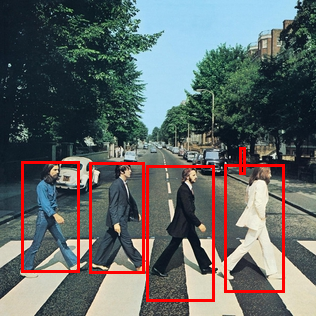

In [ ]:
import requests
test_on_beatles(model)


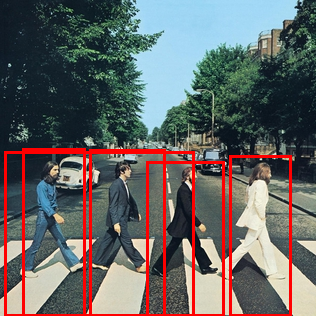

In [ ]:
test_on_beatles(backbone_model)

Upon observing the decision bounding boxes from option 1 and option 2 model, we observe that the bounding boxes in option 1 has less obstrusive overlap compared to option 2 model. Although,both the models correctly mark the four humans standing.